###9. 자전거 대여 수요 예측 실습

#### 1. 데이터 가공

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

from google.colab import drive
drive.mount('/content/drive')

bike_df = pd.read_csv(r"/content/drive/MyDrive/Euron/bike_train.csv")
print(bike_df.shape)
bike_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
bike_df.info()  # 칼럼 타입 확인하기

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [7]:
# 문자열을 datatime타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)  # datetime은 타입명

# 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x:x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x:x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x:x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x:x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [8]:
# datetime 칼럼 삭제
drop_columns = ['datetime', 'casual', 'registered']  # 'casual', 'registered'은 'count'('casual', 'registered'의 합)와 상관도가 높음 => 삭제
bike_df.drop(drop_columns, axis=1, inplace=True)

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 변환 시 NaN 발생 => log() 아닌 log1p() 이용
# RMSLE(root mean square log error)
def rmsle(y, pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred)**2
  rmsle = np.sqrt(np.mean(squared_error))

  return rmsle

# rmse
def rmse(y, pred):
  return np.sqrt(mean_squared_error(y, pred))

# mse, rmse, rmsle 계산
def evaluate_regr(y, pred):
  rmsle_val = rmsle(y, pred)
  rmse_val = rmse(y, pred)
  # MAE
  mae_val = mean_absolute_error(y, pred)
  print('RMSLE:{0:.3f}, RMSE:{1:.3F}, MAE:{2:.3F}'.format(rmsle_val, rmse_val, mae_val))


In [10]:
# log(), mean_squared_log_error() 이용 -> 오버플로/언더플로 오류가 발생할 수 있음
# def rmsle(y, pred):
#   msle = mean_squared_log_error(y, pred)
#   rmsle = np.sqrt(msle)
#   return rmsle

#### 2. 로그 변환, 피처 인코딩

In [11]:
# 회귀 예측
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg  = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE:1.165, RMSE:140.900, MAE:105.924


In [13]:
# 오류값 가장 큰 5개 확인
def get_top_error_data(y_test, pred, n_tops=5):
  # DataFrame 칼럼으로 count와 예측값 비교
  result_df = pd.DataFrame(y_test.values, columns=['real_count'])
  result_df['predicted_count'] = np.round(pred)
  result_df['diff'] = np.abs(result_df['real_count']-result_df['predicted_count'])

  # 예측값과 실제값 큰 데이터 순으로 출력
  print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


In [14]:
# 예측 오류가 꽤 크다. => Target의 분포가 왜곡된 형태인지 확인 (정규분포 형태가 아닌지 확인)

<Axes: >

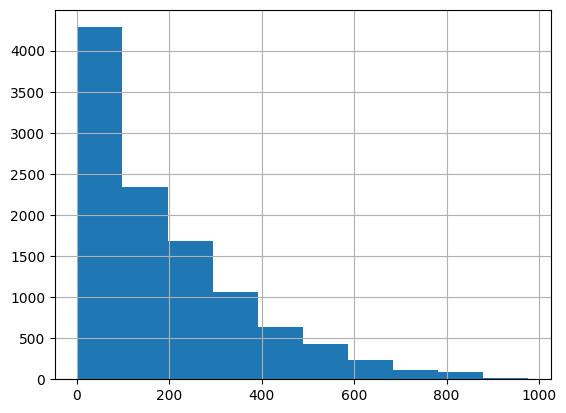

In [15]:
y_target.hist()

In [16]:
# 0~200 사이에 왜곡됨 -> 정규 분포 형태로 변환해야함 => 로그 변환

<Axes: >

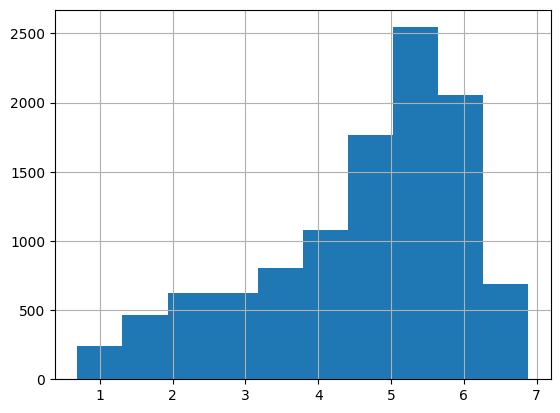

In [19]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [20]:
# 완전한 정규 분포 형태는 아니지만 왜곡 정도 향상됨

In [21]:
y_target_log = np.log1p(y_target)

# y_target_log 반영하여 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg  = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# expm1으로 원래 스케일로 변환 # expm1(exponential minus 1): e^x-1
y_test_exp = np.expm1(y_test)

# 예측값도 expm1으로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE:1.017, RMSE:162.594, MAE:109.286


In [ ]:
# RMSLE:1.165, RMSE:140.900, MAE:105.924
# RMSLE:1.017, RMSE:162.594, MAE:109.286
# RMSLE 오류 줄었지만 RMSE 늘어남

<Axes: ylabel='None'>

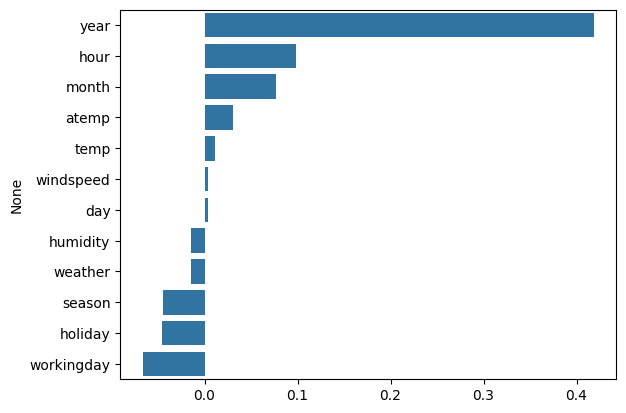

In [23]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [24]:
# year 회귀 계수값이 매우 큼
# 숫자형 값이지만 카테고리형 피처 => 원-핫 인코딩 적용

##### 선형 회귀 모델 학습

In [25]:
# One-Hot Encoding - get_dummies() 이용
X_features_ohe = pd.get_dummies(X_features, columns= ['year','month','day','hour','holiday','workingday','season','weather'])

# 원-핫 인코딩 적용된 데이터 세트에서 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

# 성능 평가 수치 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  if is_expm1:
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
  print('###',model.__class__.__name__,'###')
  evaluate_regr(y_test, pred)
# end of function

# 모델별 평가 수행
lr_reg  = LinearRegression()
ridge_reg  = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
  get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE:0.590, RMSE:97.688, MAE:63.382
### Ridge ###
RMSLE:0.590, RMSE:98.529, MAE:63.893
### Lasso ###
RMSLE:0.635, RMSE:113.219, MAE:72.803


In [26]:
# 원-핫 인코딩 적용 후 예측 성능 향상됨

<Axes: ylabel='None'>

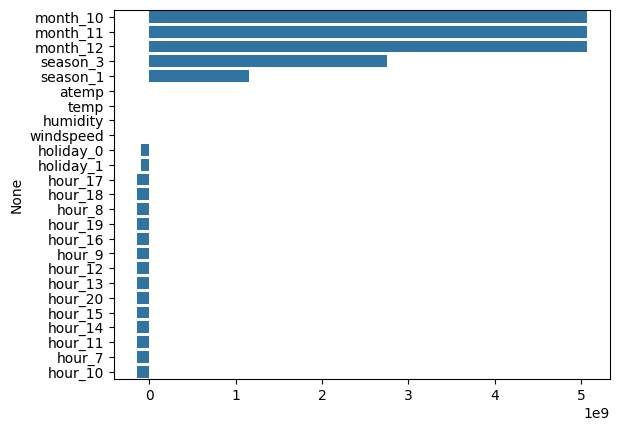

In [29]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:25]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [ ]:
# 월, 계절 등 회귀 계수 높음

##### 회귀 트리 이용

In [30]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 모델별 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)  # xgboost는 dataframe 입력시 오류 발생할 수 있음 (=> ndarray로 변환)

### RandomForestRegressor ###
RMSLE:0.355, RMSE:50.344, MAE:31.162
### GradientBoostingRegressor ###
RMSLE:0.330, RMSE:53.349, MAE:32.751
### XGBRegressor ###
RMSLE:0.339, RMSE:51.475, MAE:31.357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043
### LGBMRegressor ###
RMSLE:0.319, RMSE:47.215, MAE:29.029


### 10. 캐글 주택 가격 실습 : 고급 회귀 기법

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

house_df_org = pd.read_csv(r"/content/drive/MyDrive/Euron/house_price.csv")
house_df = house_df_org.copy()
house_df.head(3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [43]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n 전체 피처의 type \n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\n Null 칼럼과 그 건수:\n', isnull_series[isnull_series>0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

 전체 피처의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

 Null 칼럼과 그 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


In [44]:
# null이 많은 피처는 drop

<Axes: title={'center': 'Original Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

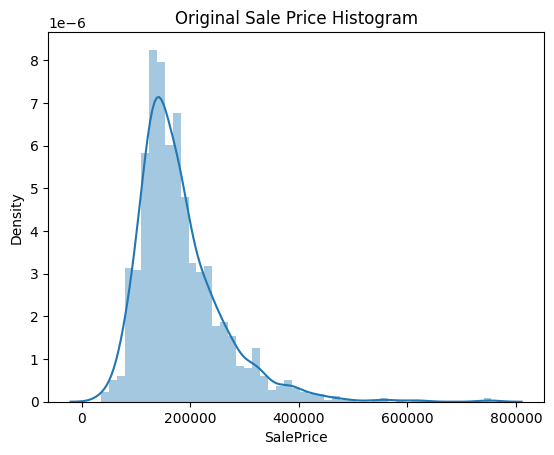

In [45]:
# target값의 분포가 정규 분포인지 확인
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

<Axes: title={'center': 'Log Transformed Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

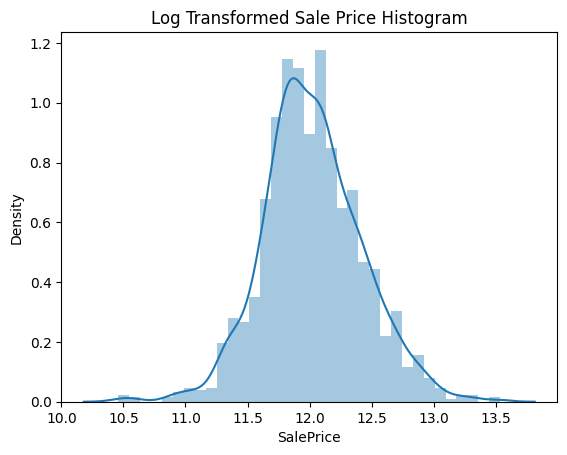

In [46]:
# log1p() - 로그변환 -> 정규분포 형태로 변환
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

In [47]:
# 정규분포 형태로 분포함

#### 데이터 사전 처리 (로그 변환 및 Null 피처 전처리)

In [48]:
# 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null 많은 칼럼과 불필요한 칼럼(단순 식별자) 삭제
house_df.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis=1,inplace=True)
# drop하지 않는 숫자형 Nul 칼럼은 평균값으로 대체
house_df.fillna(house_df.mean(numeric_only=True), inplace=True)

# Null 값 있는 피처명과 타입 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print('## Null 피처의 Type: \n', house_df.dtypes[null_column_count.index])


## Null 피처의 Type: 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [50]:
print('get_dummies() 수행 전 데이터 shape:',house_df.shape)
house_df_ohe= pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 shape:',house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print('## Null 피처의 Type: \n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 shape: (1460, 75)
get_dummies() 수행 후 데이터 shape: (1460, 270)
## Null 피처의 Type: 
 Series([], dtype: object)


In [51]:
# 피처 증가, Null 값 갖는 피처 존재하지 않음

#### 2. 선형 회귀 모델 학습/예측/평가

In [52]:
def get_rmse(model):
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test, pred)
  rmse = np.sqrt(mse)
  print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 3))
  return rmse

def get_rmses(models):
  rmses=[]
  for model in models:
    rmse = get_rmse(model)
    rmses.append(rmse)
  return rmses

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# lr, ridge, lasso 학습, 예측, 평가
lr_reg  = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg  = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.127
Lasso 로그 변환된 RMSE: 0.176


[0.13183184688250854, 0.1274058283626615, 0.17628250556471403]

In [54]:
# 모델별 피처 회귀 계수
def get_top_bottom_coef(model, n=10):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명.
    coef = pd.Series(model.coef_, index=X_features.columns)

    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

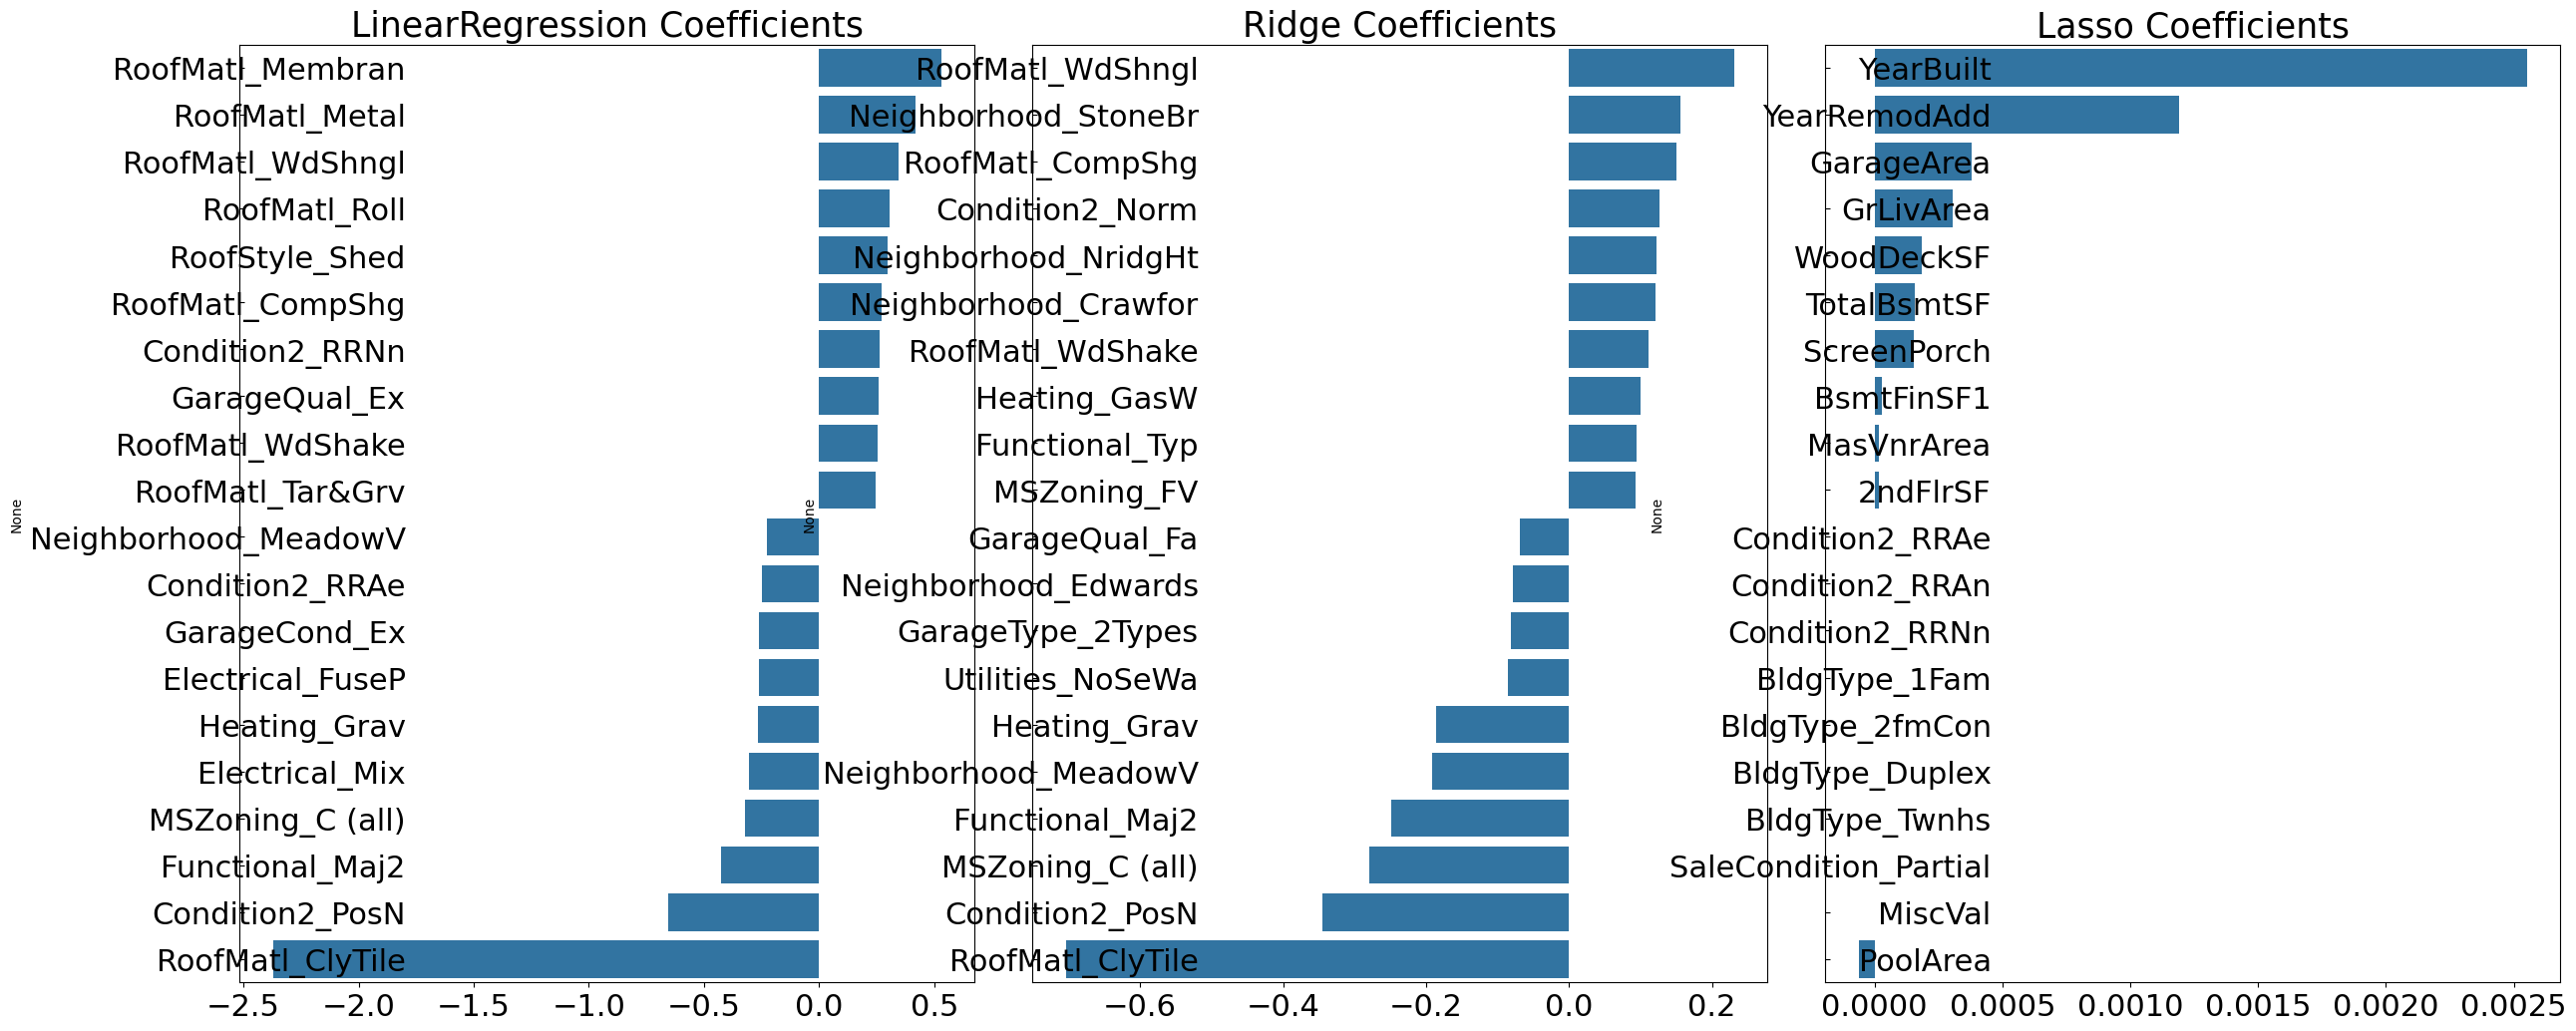

In [55]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout()
    # models에서 차례로 model 추출해서 회귀 계수 시각화함
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 판다스 concat으로 결합
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정.
        axs[i_num].set_title(model.__class__.__name__+' Coefficients', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [56]:
# Lasso 회귀 계수가 나머지 모델과 다른 형태임 (회귀 계수 값이 매우 작음) -> 데이터 분할에 문제가 있는 것인지 확인
# => 교차 검증 폴드 세트로 분할

In [57]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.167 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


In [58]:
# Lasso 성능이 가장 떨어짐 => ridge, lasso 최적의 하이퍼 파라미터 값(alpha) 찾기

from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.142, 최적 alpha:{'alpha': 0.001}


In [59]:
# lasso 모델 성능 많이 개선됨

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


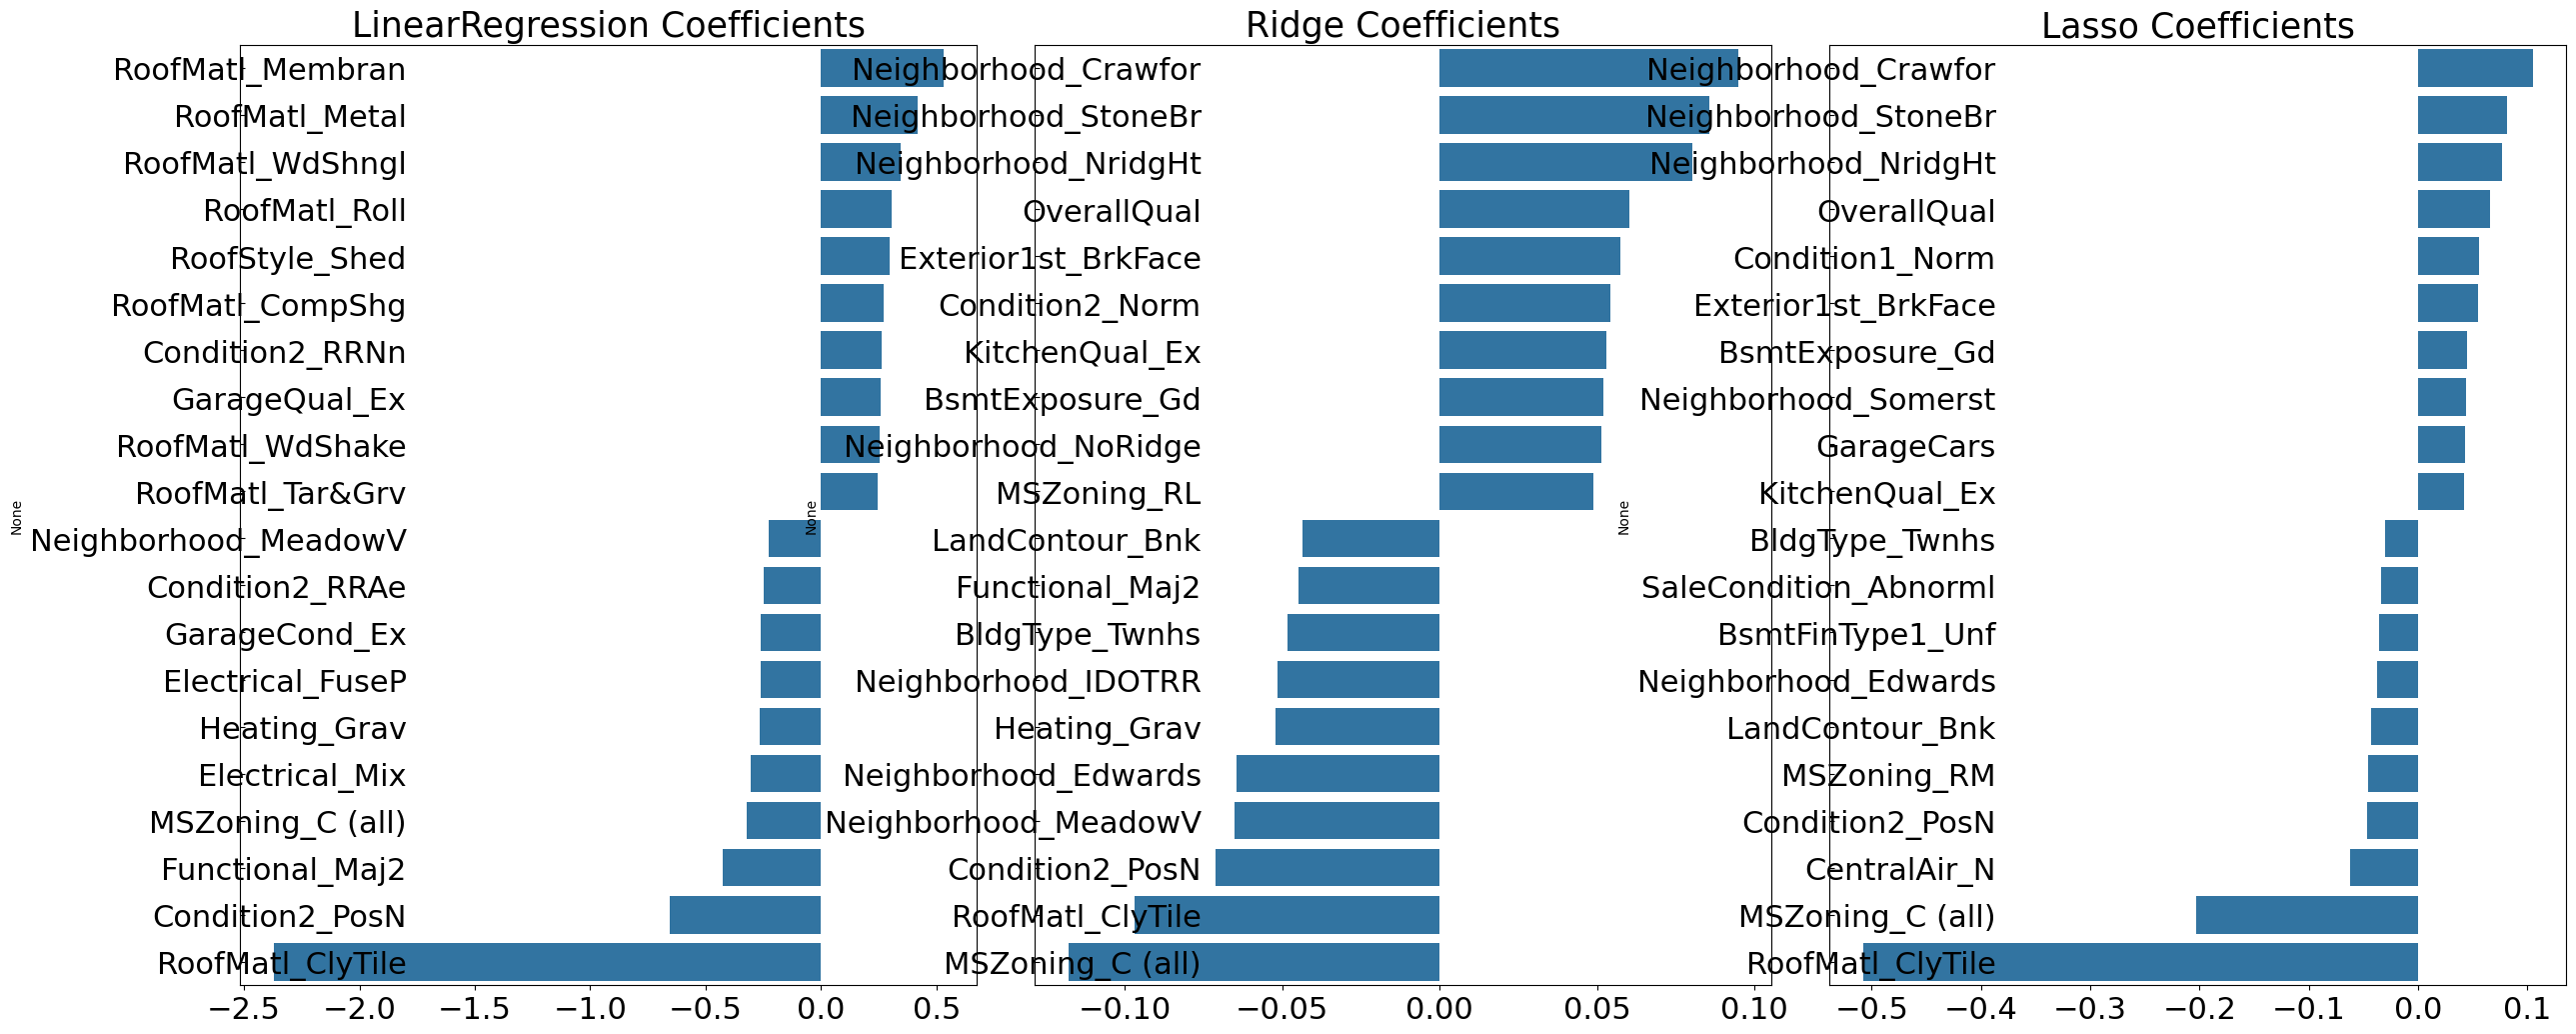

In [60]:
# 최적화 alpha 값으로 학습 데이터 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [ ]:
# alpha 최적화 전 RMSE: 0.176 -> 최적화 후 RMSE: 0.12 (예측 성능 향상)
# 모델별 비슷한 피처의 회귀 계수 많아짐. 다만, lasso는 회귀계수 값이 상당히 작음.

* 데이터 세트의 분포도 확인 (로그 변환)

In [61]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 [ ]로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew( ) 호출
skew_features = house_df[features_index].apply(lambda x : skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [62]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index]) # 왜곡 정도 높은 피처 로그 변환

In [63]:
# 왜곡 정도 높은 피처를 로그 변환함 => 다시 원-핫 인코딩 적용, 피처/타겟 데이터 세트 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1275, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1252, 최적 alpha:{'alpha': 0.001}


Lasso(alpha=0.001)

In [64]:
# 릿지 모델 최적 alpha값 12->10 변화
# 릿지, 라쏘 모두 피처 로그 변환 후 RMSE값 향상됨

LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.122
Lasso 로그 변환된 RMSE: 0.119


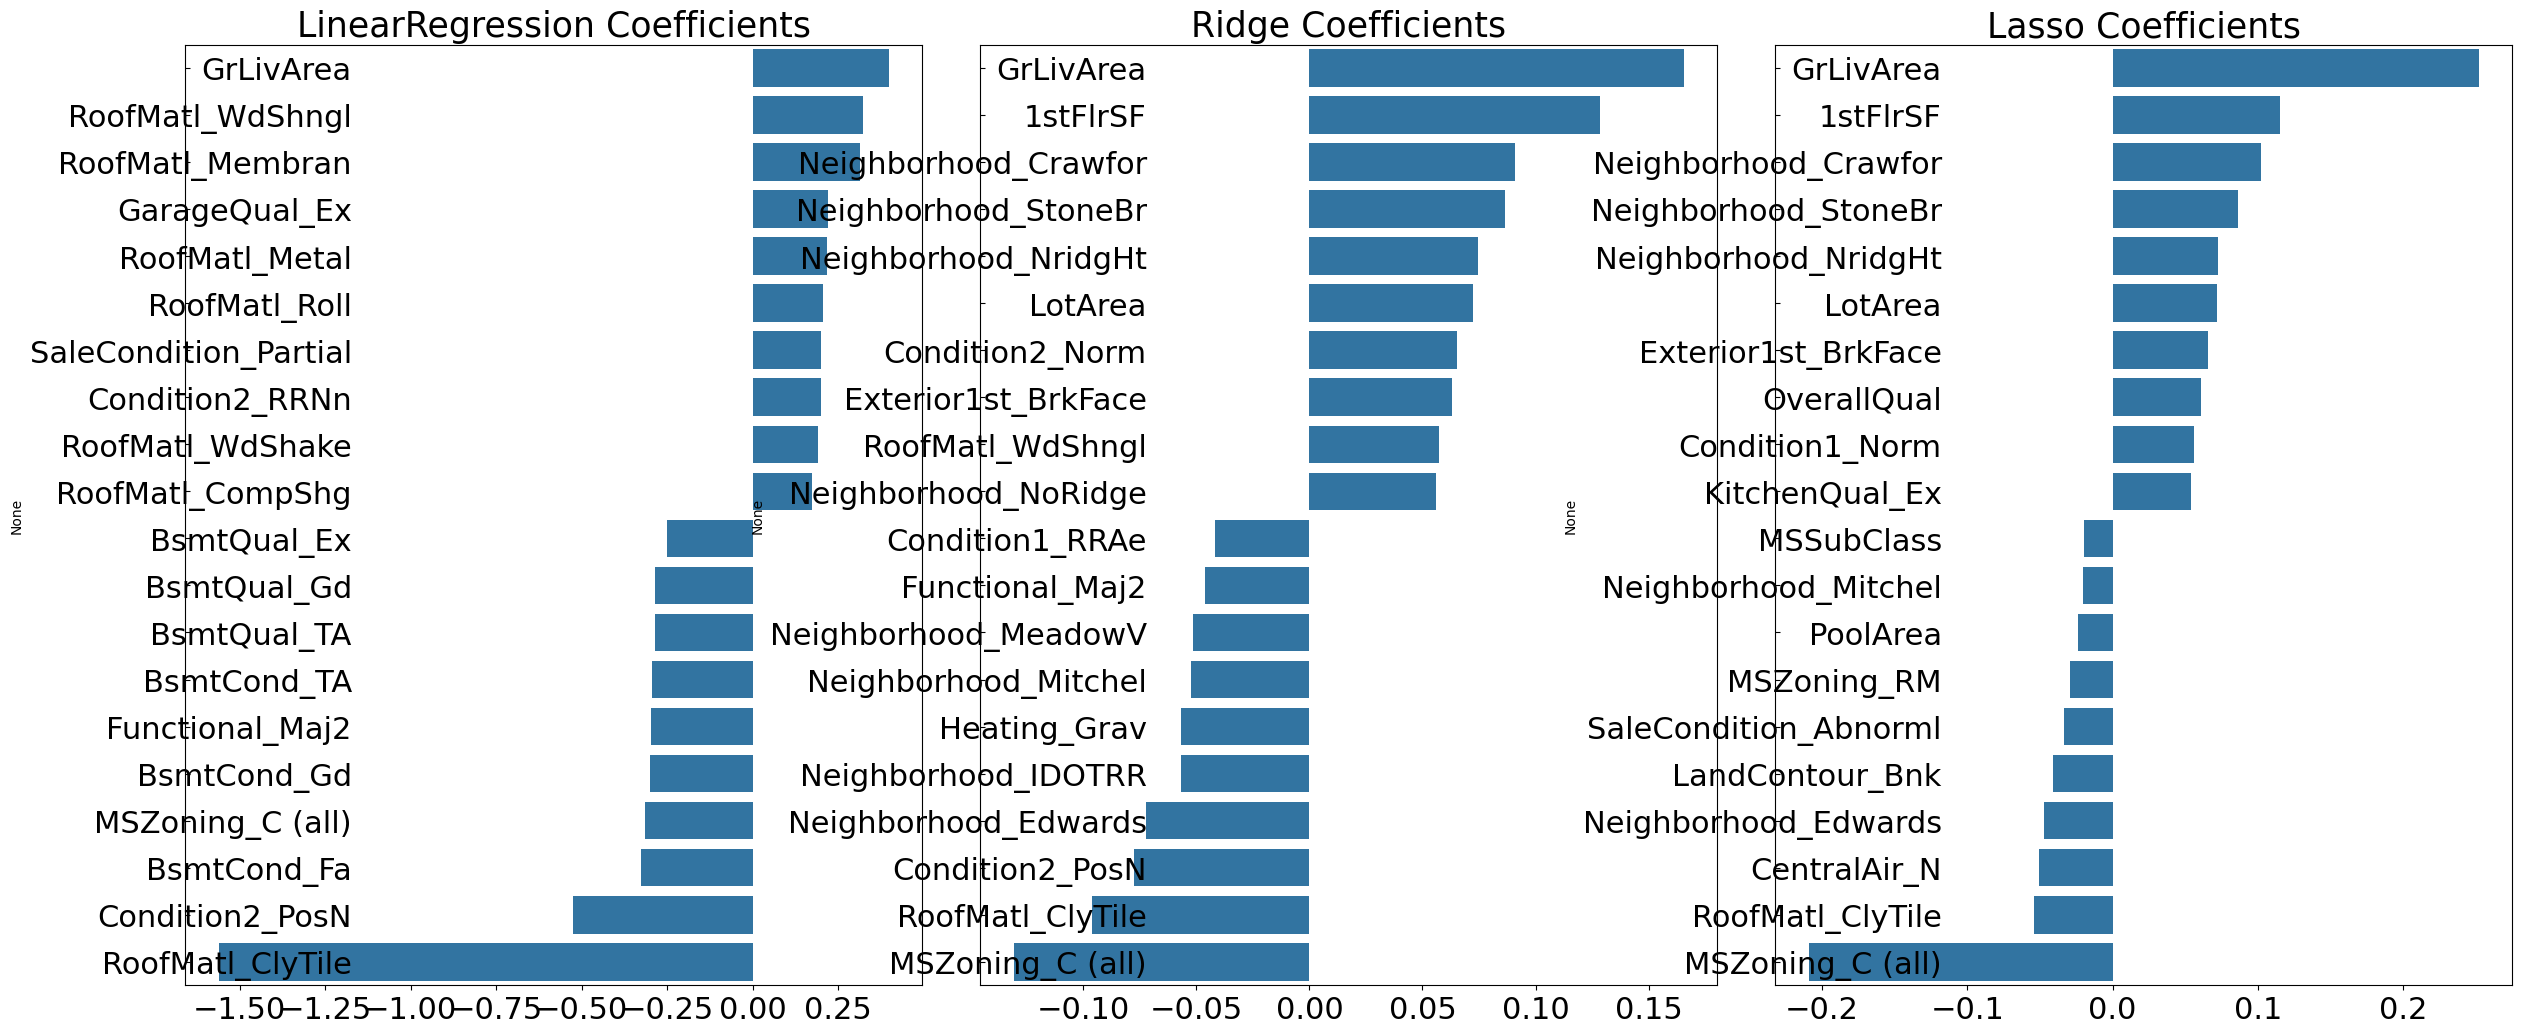

In [65]:
# 최적화 alpha 값으로 학습 데이터 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [66]:
# 세 모델 모두 GrLivArea(주거 공간 크기)가 회귀 계수가 가장 높은 피처가 됨

* 이상치 데이터 분석

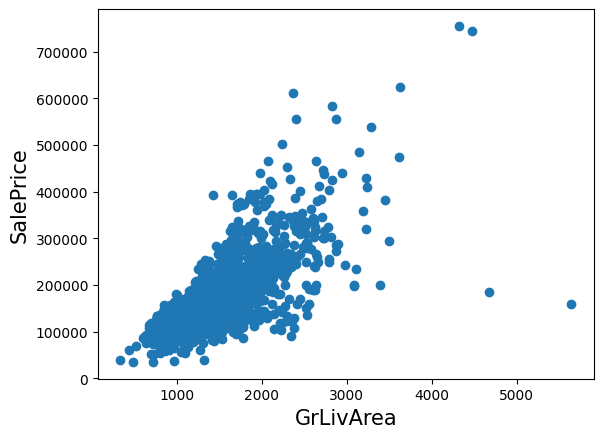

In [67]:
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [68]:
# 대체로 양의 상관도 높음
# 그러나, GrLivArea>4000 일때 이상치 발견

In [69]:
# GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건 생성
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index :', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape:', house_df_ohe.shape)

# DataFrame의 index를 이용 -> 이상치 레코드 삭제.
house_df_ohe.drop(outlier_index , axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

이상치 레코드 index : [ 523 1298]
이상치 삭제 전 house_df_ohe shape: (1460, 270)
이상치 삭제 후 house_df_ohe shape: (1458, 270)


In [70]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2,
                                                    random_state=156)

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1122, 최적 alpha:{'alpha': 0.001}


Lasso(alpha=0.001)

In [ ]:
# [Ridge] 최적 평균 RMSE 값: 0.1275 -> 0.1125, 최적 alpha:{'alpha': 10} -> {'alpha': 8}
# [Lasso] 최적 평균 RMSE 값: 0.1252 -> 0.1122, 최적 alpha:{'alpha': 0.001} -> {'alpha': 0.001}

LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.103
Lasso 로그 변환된 RMSE: 0.1


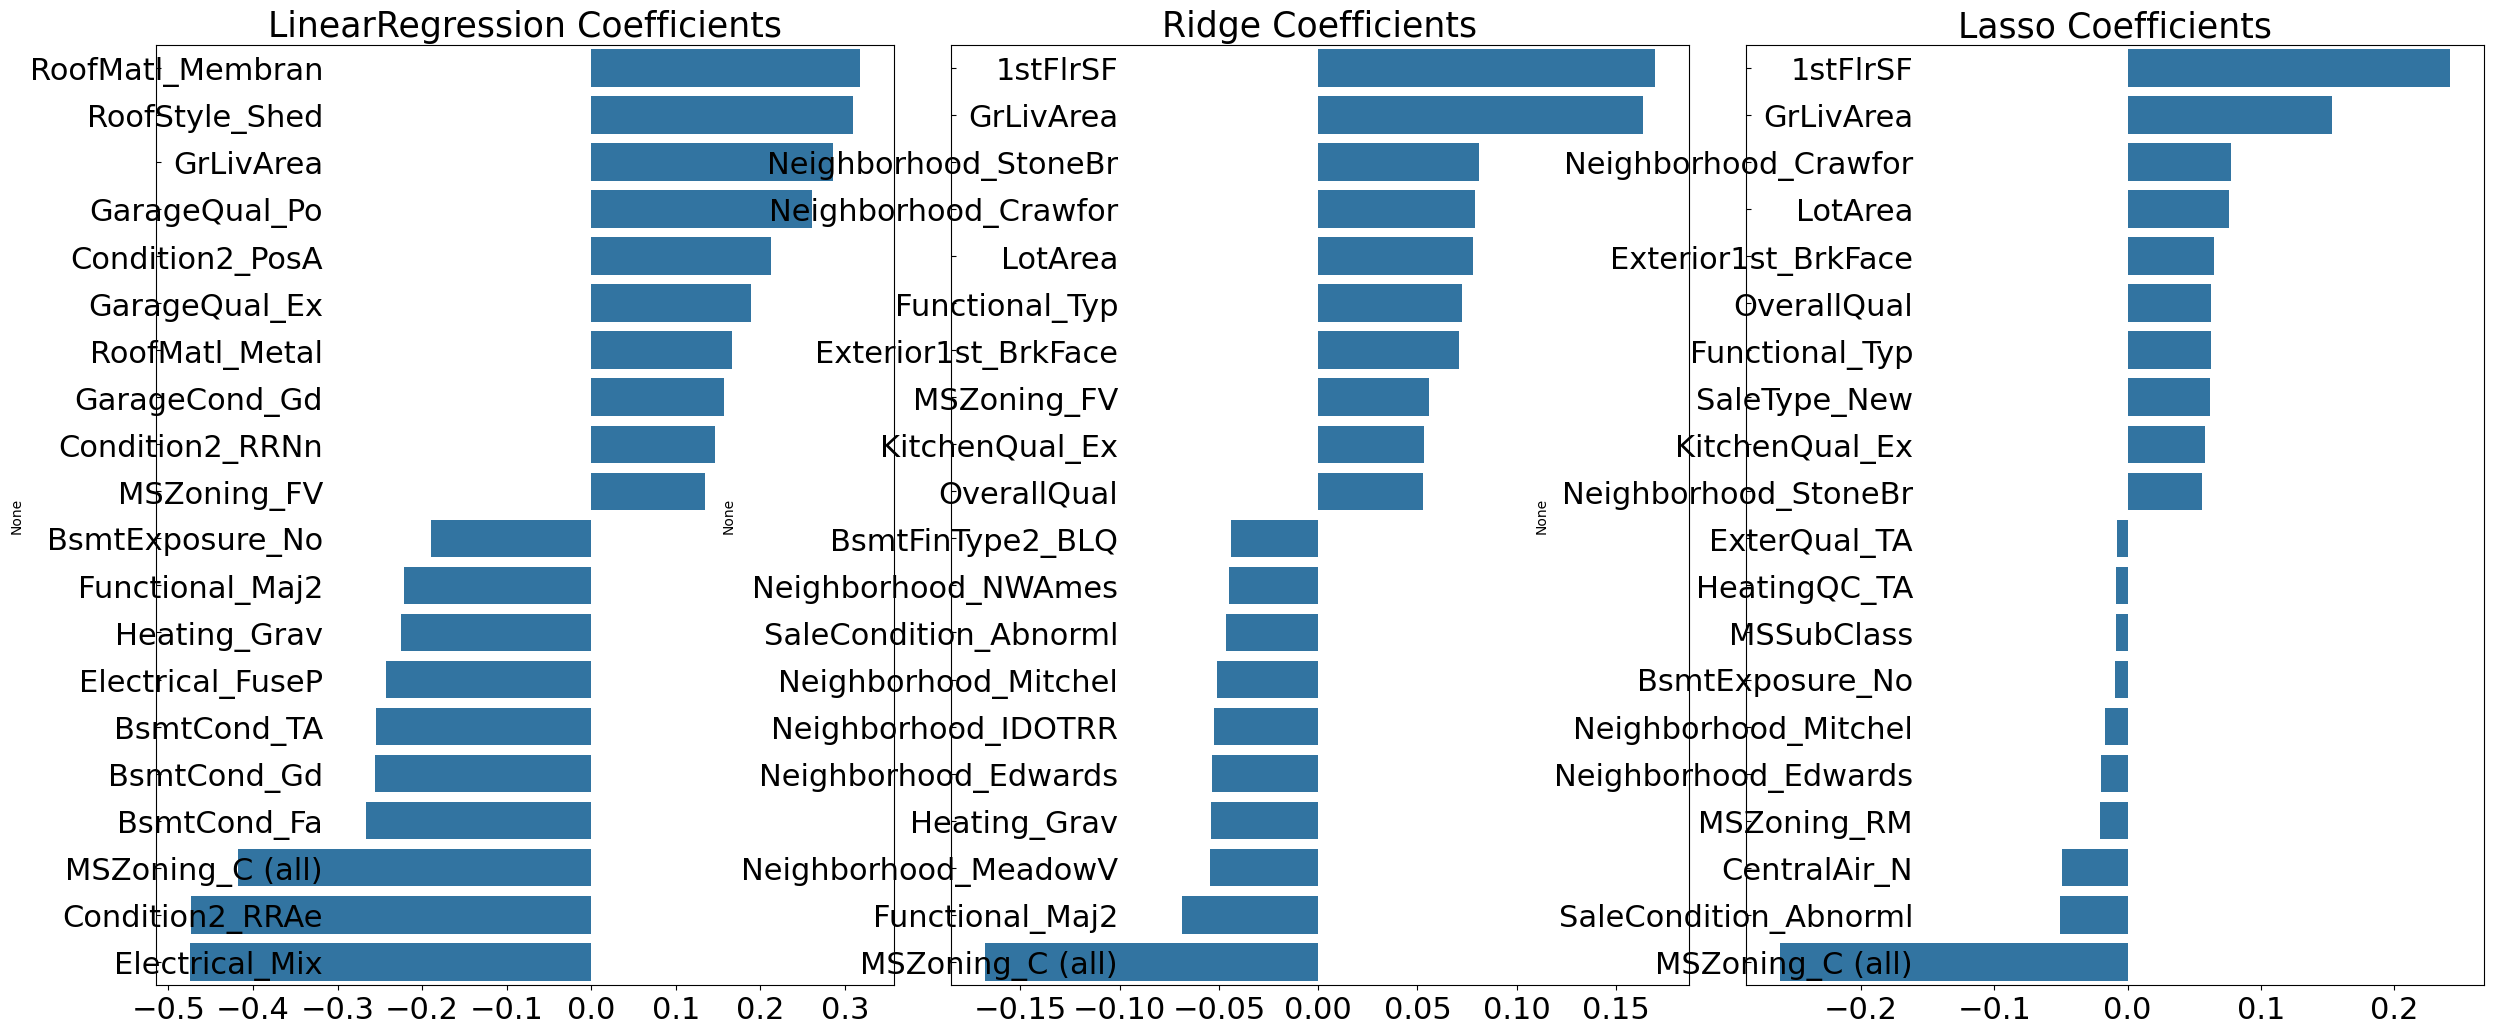

In [71]:
# 최적화 alpha 값으로 학습 데이터 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

#### 회귀 트리 모델 학습/예측/평가

In [72]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1185, 최적 alpha:{'n_estimators': 1000}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [73]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1189, 최적 alpha:{'n_estimators': 1000}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1, num_leaves=4,
             num_parallel_tree=None, ...)

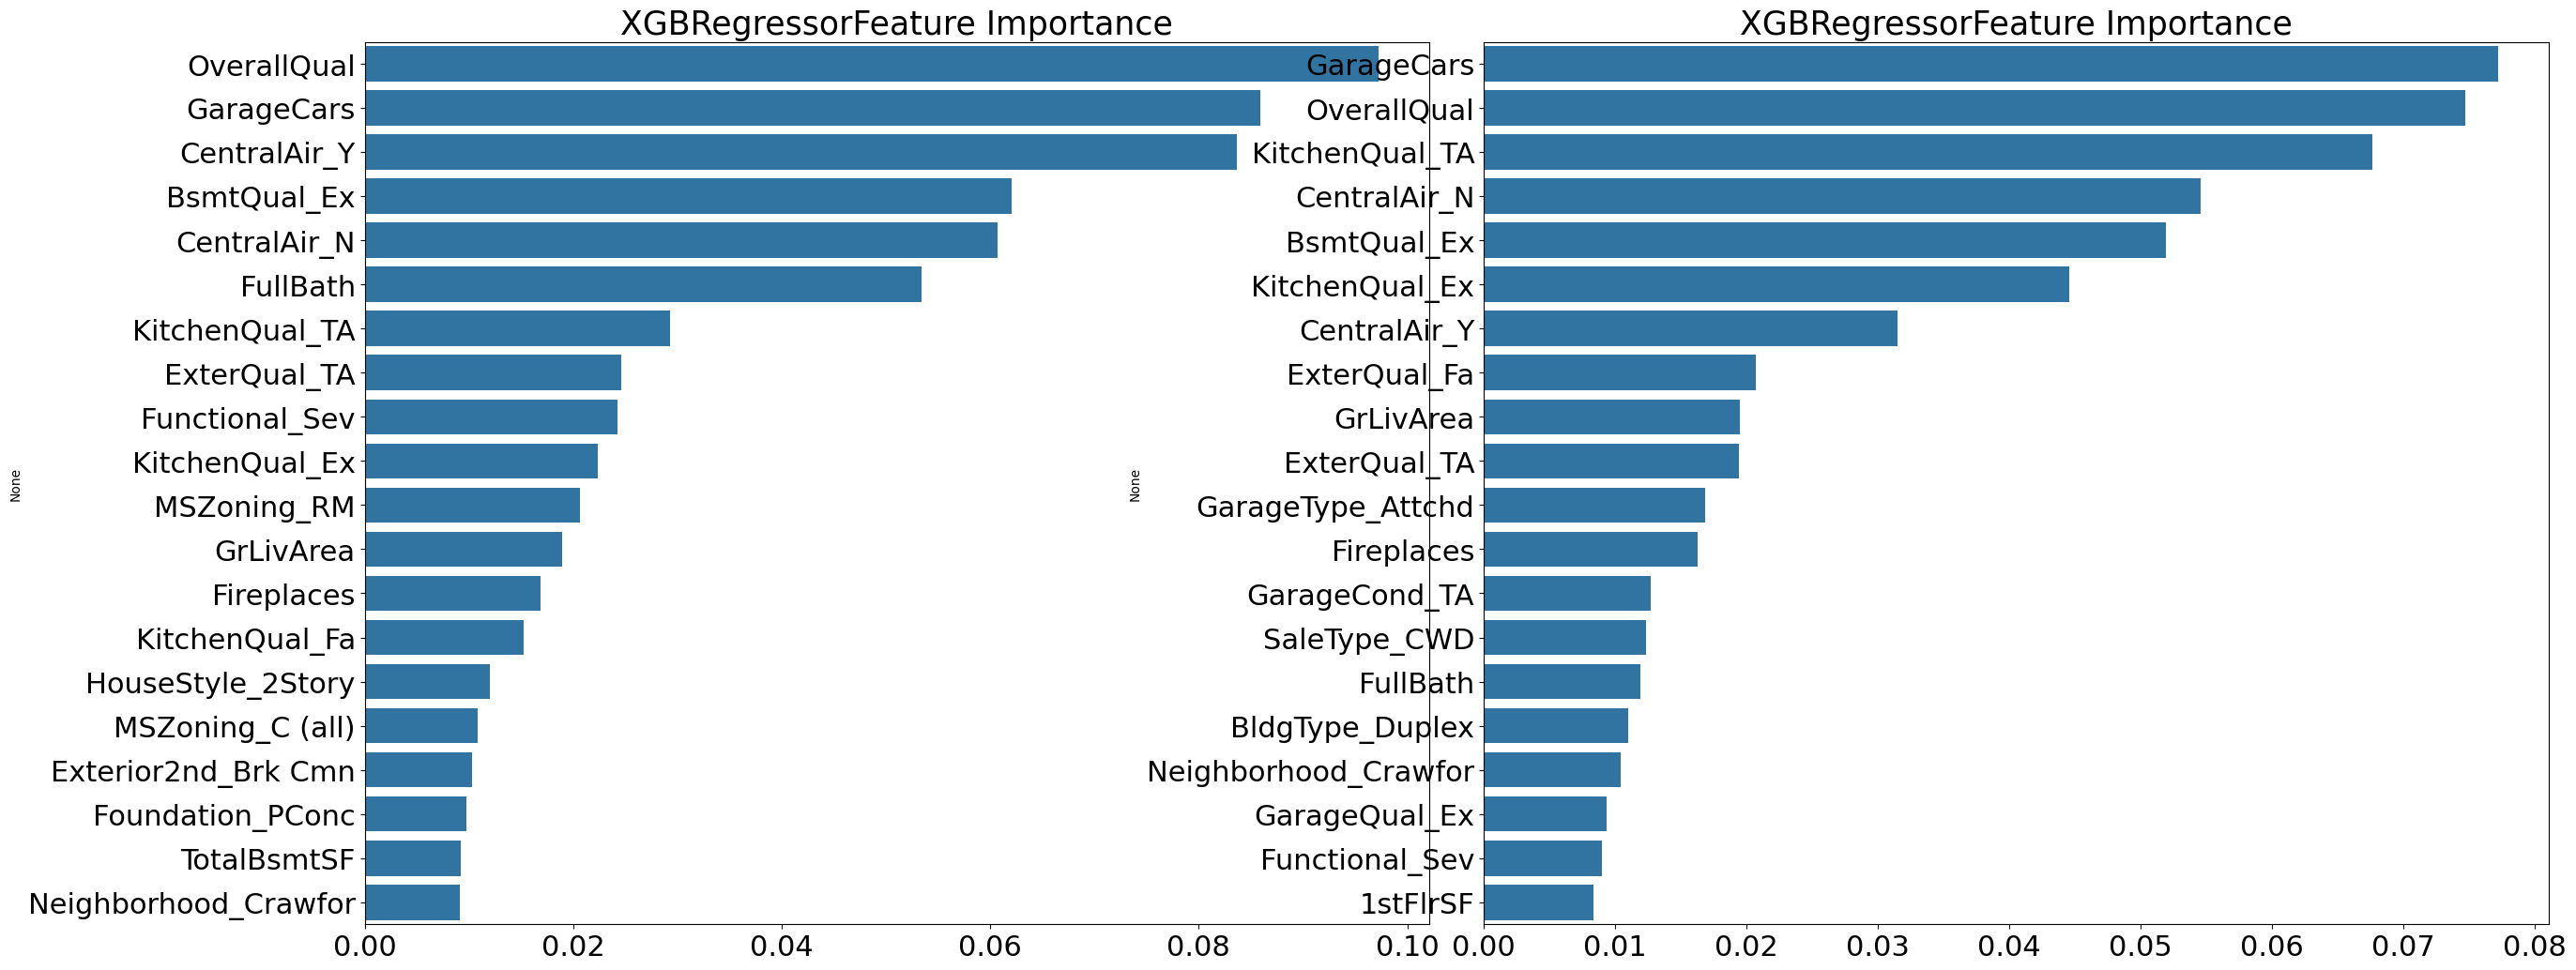

In [90]:
# 회귀 트리 Regressor 클래스는 coef_ 속성 없음 => 피처별 중요도

def get_top_feature(model):
  feature_series = pd.Series(data=model.feature_importances_, index=X_features.columns )
  feature_series = feature_series.sort_values(ascending=False)[:20]
  return feature_series

def visualize_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout()
    # models에서 차례로 model 추출해서 회귀 계수 시각화함
    for i_num, model in enumerate(models):
        # 상위 20개 피처를 구함
        ftr_top_importance = get_top_feature(model)
        axs[i_num].set_title(model.__class__.__name__+'Feature Importance', size=25)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top_importance.values, y=ftr_top_importance.index , ax=axs[i_num])

# 앞 예제에서 학습한 xgb_reg, lgbm_reg 모델의 피처 중요도 시각화
models = [xgb_reg, lgbm_reg]
visualize_importances(models)

#### 회귀 모델의 예측 결과 혼합을 통한 최종 예측

In [76]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10006075517615194
Ridge 모델의 RMSE: 0.10340697165289348
Lasso 모델의 RMSE: 0.10024171179335342


In [78]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

# 개별 모델의 학습
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
# 개별 모델 예측
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10444281157931944
XGBM 모델의 RMSE: 0.10749463285555907
LGBM 모델의 RMSE: 0.10602609182774048


#### 스태킹 앙상블 모델을 통한 회귀 예측

In [81]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [82]:
# get_stacking_base_datasets( ): 넘파이 ndarray를 인자로 사용함 => DataFrame을 넘파이로 변환.
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [85]:
# 개별 모델이 반환한 학습용/테스트용 데이터 세트 결합
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)  # axis=1: column 방향
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델: lasso
meta_model_lasso = Lasso(alpha=0.0005)

# 개별 모델 예측값 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측, RMSE 측정
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은 :',rmse)

스태킹 회귀 모델의 최종 RMSE 값은 : 0.09759937848928928


In [86]:
# 스태킹 회귀 모델: 가장 좋은 성능 평가